### Install/Import libraries
We'll be using numpy, pandas, and xarray for preprocessing, matplotlib for vizualization, tensorflow to construct and train the model, and the last two are dependencies needed to open the dataset.

In [ ]:
! pip install numpy pandas matplotlib xarray tensorflow netcdf4 xarray[io]

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
from tensorflow import keras
import os

### Load dataset
Xarray is an alternative for pandas that works for multidimensional data. Xarray supports common pandas functionality, which means our pandas knowledge won't go to waste. Let's open the dataset using xarray by passing the filepath of the .nc file. This notebook assumes it's in the same directory as the 'Scorched Earth Data' folder. I prefer to have the data be in a separate folder from preprocessing. You can change the folder name to whatever you like.

In [189]:
filename = 'Mongolia_2D_ERA5_2010_2024.nc'
fullpath = os.path.join(os.getcwd(), 'Scorched Earth Data', filename)
dataset = xr.open_dataset(fullpath)
dataset

<xarray.Dataset> Size: 39MB
Dimensions:    (time: 5373, step: 24, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 40B 47.8 47.7 47.6 47.5 47.4
  * longitude  (longitude) float64 40B 106.4 106.5 106.6 106.7 106.8
  * step       (step) timedelta64[ns] 192B 01:00:00 02:00:00 ... 1 days 00:00:00
  * time       (time) datetime64[ns] 43kB 2009-12-31 2010-01-01 ... 2024-03-31
Data variables:
    d2m        (time, step, latitude, longitude) float32 13MB ...
    sp         (time, step, latitude, longitude) float32 13MB ...
    t2m        (time, step, latitude, longitude) float32 13MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 19 16:26:46 2024: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

There's a lot going on here so let's break it down. Each of the three data variables are a 4D numpy array with dimensions, or coordinates, (time, step, latitude, longitude). Unlike with regular numpy arrays, xarray allows us to label these dimensions by wrapping the 4D numpy array in a DataArray. This let's you provide labels to these dimensions similarly to how you could with pandas Series. Time represents the number of days in the dataset. Step represents the number of hourly samples within the day. Lastly, latitude and longitude are self explanatory. 

## Preprocessing

While our ERA5-Land temperature data is very organized and carefully curated, real-world data can have missing data, contain outliers, be noisy, or inconsistent.

### Checking for missing data.

In xarray, missing or null values are represented as NaNs for Not a Number. It's a special floating-point value from NumPy to show that it is undefined or unrepresentable. Xarray provides multiple functions to handle these, and one of them is the **count()** function. From Xarray docs: "used to count the number of non-missing values along one or more dimensions of an xarray object. It returns a new xarray object with the same dimensions as the original object, but with each element replaced by the count of non-missing values along the specified dimensions." Given time, step, latitude, and longitude have dimensions 5373, 24, 5, and 5, respectively, we should have a count of 5373 * 24 * 5 * 5 = 3,223,800 non-missing values.

In [190]:
dataset["t2m"].count(dim=['time', 'step', 'latitude', 'longitude'])

<xarray.DataArray 't2m' ()> Size: 4B
array(3121200)

There are 102,600 missing values. There are multiple ways to deal with them. If you're familiar with pandas, you can use **dropna()** and **fillna()**. From Xarray docs: "dropna() is a method in xarray that can be used to remove missing or null values from an xarray object. It returns a new xarray object with the same dimensions as the original object, but with missing values removed." This will end up reducing the dimensions. The function is sensitive and will drop entire rows/columns if any NaN values appear. You can change the condition to only drop columns/rows if all values are NaNs. Sometimes you don't want to reduce dimensions and remove crucial training samples. We can use **fillna()** to replace the NaNs with the previous time step's temperature or an average. For now, we will drop the any time steps that contain any NaNs and will be something to reinvestigate later.

In [191]:
clean_ds = dataset.dropna(dim="time", how="any")

In [192]:
clean_ds.count(dim=['time', 'step', 'latitude', 'longitude'])

<xarray.Dataset> Size: 12B
Dimensions:  ()
Data variables:
    d2m      int32 4B 3018600
    sp       int32 4B 3018600
    t2m      int32 4B 3018600

Now that we checked for missing values, here's what the data looks like again. In xarray, you can index for specific data using **isel()**. This is how you would select for the first time step of the first day.

In [193]:
clean_ds.isel(time=0)

<xarray.Dataset> Size: 7kB
Dimensions:    (step: 24, latitude: 5, longitude: 5)
Coordinates:
  * latitude   (latitude) float64 40B 47.8 47.7 47.6 47.5 47.4
  * longitude  (longitude) float64 40B 106.4 106.5 106.6 106.7 106.8
  * step       (step) timedelta64[ns] 192B 01:00:00 02:00:00 ... 1 days 00:00:00
    time       datetime64[ns] 8B 2010-01-01
Data variables:
    d2m        (step, latitude, longitude) float32 2kB 244.7 244.9 ... 243.9
    sp         (step, latitude, longitude) float32 2kB 8.52e+04 ... 8.24e+04
    t2m        (step, latitude, longitude) float32 2kB 247.8 248.0 ... 246.7
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 Fri Jul 19 16:26:46 2024: C:\Users\sguti\minicon...
    NCO:                     netCDF Operators version 5.2.4 (Homepage = http:...

### Changing to a 1D Dataset 
The dataset contains a 5x5 grid of weather variables sampled at every hour. We won't need the entire grid for non-CNN models, and we'll only be using the values at the center. Furthermore, the temperature is organized by day and hour. It will be easier to manipulate and visualize the data if the dataset had a single datetime dimension. We'll create a new dataset with these characteristics.

In [227]:
days = clean_ds.coords['time'].shape[0]

rows = days * 24
hourly_t2m_ds = np.empty(shape=(rows))
hourly_d2m_ds = np.empty(shape=(rows))
hourly_sp_ds = np.empty(shape=(rows))

row = 0
for x in range(days):
	for y in range(24):
		hourly_t2m_ds[row] = clean_ds["t2m"][x, y, 2, 2]
		hourly_d2m_ds[row] = clean_ds["d2m"][x, y, 2, 2]
		hourly_sp_ds[row] = clean_ds["sp"][x, y, 2, 2]

		row += 1

Time steps are in nanoseconds. I'll change them for hours so that plots are more readable.

In [228]:
clean_ds.coords["step"] = ["00:00:00", "01:00:00", "02:00:00", "03:00:00", "04:00:00", "05:00:00", "06:00:00", "07:00:00","08:00:00","09:00:00", "10:00:00", "11:00:00", "12:00:00", "13:00:00", "14:00:00", "15:00:00", "16:00:00", "17:00:00","18:00:00", "19:00:00", "20:00:00", "21:00:00", "22:00:00","23:00:00"]
clean_ds.coords["step"] 

<xarray.DataArray 'step' (step: 24)> Size: 768B
array(['00:00:00', '01:00:00', '02:00:00', '03:00:00', '04:00:00', '05:00:00',
       '06:00:00', '07:00:00', '08:00:00', '09:00:00', '10:00:00', '11:00:00',
       '12:00:00', '13:00:00', '14:00:00', '15:00:00', '16:00:00', '17:00:00',
       '18:00:00', '19:00:00', '20:00:00', '21:00:00', '22:00:00', '23:00:00'],
      dtype='<U8')
Coordinates:
  * step     (step) <U8 768B '00:00:00' '01:00:00' ... '22:00:00' '23:00:00'

Making a datetime dimension to replace the previous time and step ones.

In [229]:
dateTimeCoords = []
for date in clean_ds.coords["time"].values:
	for time in clean_ds.coords["step"].values:
		dateTime = str(date)[:11] + time
		dateTimeCoords.append(dateTime)

In [230]:
clean_hourly_ds = xr.Dataset(
    data_vars=dict(
        t2m=(["datetime"], hourly_t2m_ds),
        d2m=(["datetime"], hourly_d2m_ds),
		sp=(["datetime"], hourly_sp_ds),
    ),
    coords=dict(
        datetime=("datetime", np.array(dateTimeCoords, dtype='datetime64[h]'))
    ),
    attrs=dict(description="Hourly data from 2010-01-01 to 2024-03-30 at 47.6N 106.6E Ulaanbaatar, Mongolia."),
)

C:\Users\sguti\AppData\Local\Temp\ipykernel_21224\2520399145.py:1: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  clean_hourly_ds = xr.Dataset(


In [231]:
clean_hourly_ds[["t2m", "d2m", "sp"]]

<xarray.Dataset> Size: 4MB
Dimensions:   (datetime: 120744)
Coordinates:
  * datetime  (datetime) datetime64[ns] 966kB 2010-01-01 ... 2024-03-30T23:00:00
Data variables:
    t2m       (datetime) float64 966kB 249.6 250.4 252.8 ... 269.1 269.5 271.2
    d2m       (datetime) float64 966kB 246.9 247.9 248.8 ... 264.5 264.4 264.6
    sp        (datetime) float64 966kB 8.5e+04 8.508e+04 ... 8.54e+04 8.543e+04
Attributes:
    description:  Hourly data from 2010-01-01 to 2024-03-30 at 47.6N 106.6E U...

### Changing Kelvin to Fahrenheit 

2 meter temperature and dewpoint temperature are in Kelvin. We will need to change it to make analysis more readable. We first need to convert K to C using **C = K - 273.15**. Then convert C to F using **F = (9/5) * C + 32**. Substituing C for K: **F = (9/5) * (K - 273.15) + 32**. Since the underlying data structure is a NumPy array, every math operator against the DataArray is applied element-wise. 

In [199]:
clean_hourly_ds["t2m"] = 9/5 * (clean_hourly_ds["t2m"] - 273.15) + 32
clean_hourly_ds["t2m"][:5]

<xarray.DataArray 't2m' (datetime: 5)> Size: 20B
array([-10.466057 ,  -8.8965225,  -4.705433 ,  -1.6325836,   1.2626171],
      dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 40B 2010-01-01 ... 2010-01-01T04:00:00

In [200]:
clean_hourly_ds["d2m"] = 9/5 * (clean_hourly_ds["d2m"] - 273.15) + 32
clean_hourly_ds["d2m"][:5]

<xarray.DataArray 'd2m' (datetime: 5)> Size: 20B
array([-15.22105 , -13.519104, -11.755661, -10.515003,  -8.389423],
      dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 40B 2010-01-01 ... 2010-01-01T04:00:00

The surface pressure is currently in pascals. Scaling the values down may help with model performance. To convert to hectopascals, divide Pa by 100.

In [201]:
clean_hourly_ds["sp"] /= 100
clean_hourly_ds["sp"][:5]

<xarray.DataArray 'sp' (datetime: 5)> Size: 20B
array([850.03937, 850.7587 , 851.1075 , 851.28687, 851.21375],
      dtype=float32)
Coordinates:
  * datetime  (datetime) datetime64[ns] 40B 2010-01-01 ... 2010-01-01T04:00:00

## Data Visualization (Exploratory Data Analysis)

Xarray provides some nice interfaces to help with creating plots.

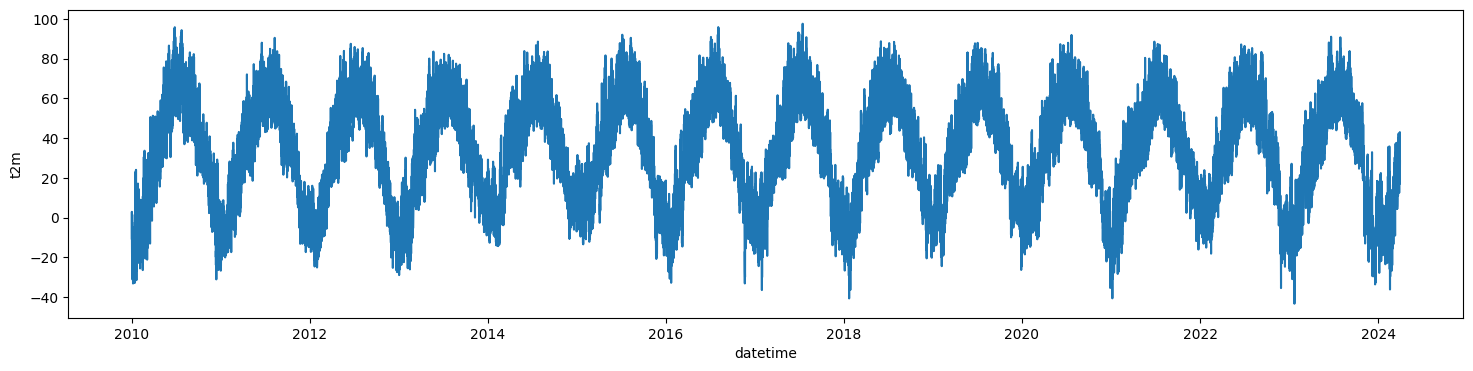

In [202]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
clean_hourly_ds["t2m"].plot(ax=ax)

There are clear peaks and valleys indicating seasonal changes in temperature. It may be useful to extract seasonality and trend information for long-term forecasts.

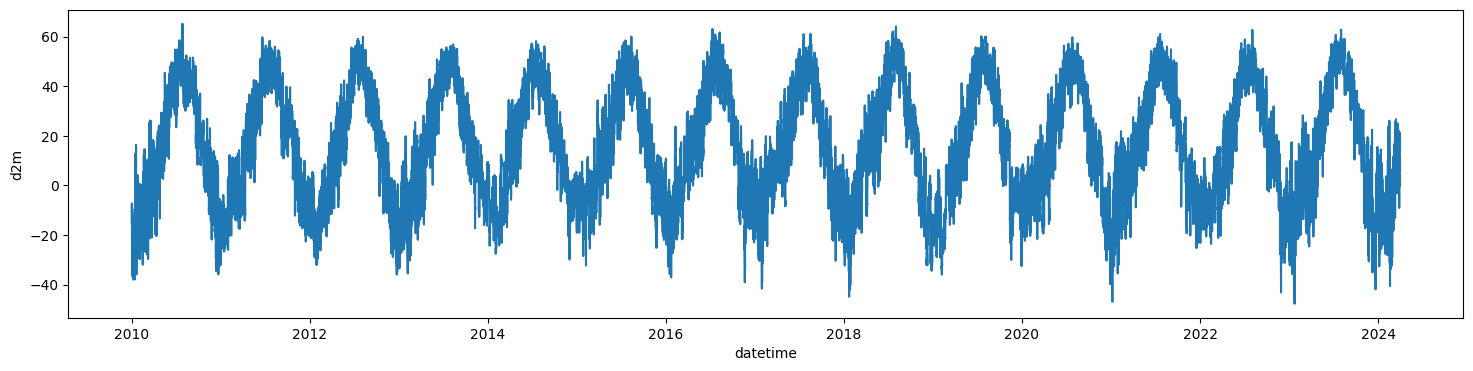

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
clean_hourly_ds["d2m"].plot(ax=ax)

Dewpoint temperature shares similar peaks and valleys. There seems to be less variance in dewpoint temperature compared to the surface temperature. This may be an artifact of how I handled missing values.

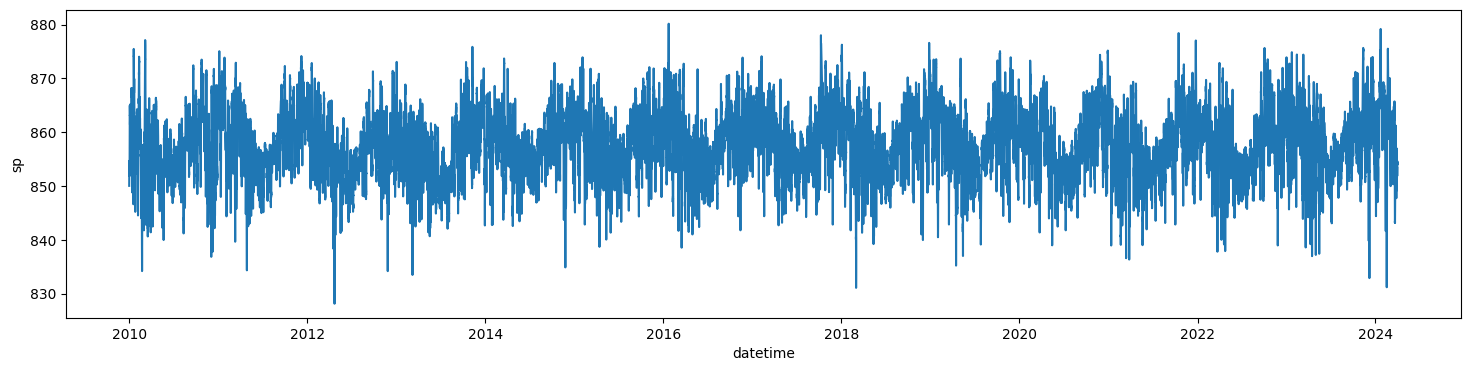

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
clean_hourly_ds["sp"].plot(ax=ax)

Surface pressure data is very noisy. For now, we will use the data as-is and make changes later.

## Feature Engineering

As previously mentioned, I could make seasonality and trend features. For now, we'll use only those three variables/features.

### Supervised Learning and Time Series Forecasting
The task of weather prediction is classified as a supervised learning task. That means that for every input, there is an expected output for the machine/deep learning algorithm to match; given an input sequence of time steps in the past, there is an output sequence of time steps in the future. Since we're trying to predict future daily/hourly temperature, we can define a time step to be a day. We will be taking these time steps and turning them into input and output sequences. For example, if we wanted to predict the next time step (the next hour) into the future, we might choose to use the past 24 time steps (the current day) as the input sequence. In time series analysis, the previous time steps are referred to as the lag time. The future time steps are referred to as the lead time. 

In [205]:
lag_time = 24
lead_time = 1
window = lag_time + lead_time

We need a function that will split the dataset into input and output sequences. This **make_supervised()** function does that. It takes in the lag and lead time, the length of the dataset, and the number of variables/features the dataset has. The function will be used to create training, validation, and test sets. These datasets are crucial for the tuning and evaluation of the machine/deep learning model. The function will slide a window across all time steps and create an input and output sequence. Then, it slide the window over so that the next window doesn't overlap with the current window. The reason we're not overlapping them is because there's a high chance that the model will overfit the training dataset. Overfitting is when the model performs far better on the training set than on the validation/test set. 

At the expense of having less training samples, we'll use non-overlapping windows to avoid overfitting.

The last line in the function converts the list into a NumPy array so we can easily do some data manipulation.

In [206]:
def make_supervised(dataset, lag_time, lead_time, dataset_size, features=1):
	# make_supervised(): Creates overlapping samples

	window = lag_time + lead_time 
	rows = dataset_size - window

	if features == 1:
		inputs = np.empty((rows, lag_time))
	else:
		inputs = np.empty((rows, lag_time, features))

	outputs = np.empty((rows, lead_time))

	for i in range(rows):
		x = dataset.iloc[i:(i+lag_time)]

		if features == 1:
			y = dataset.iloc[i+lag_time]
			inputs[i, :] = x
			outputs[i, :] = y
		else:
			y = dataset.iloc[i+lag_time]["t2m"]
			inputs[i, :, :] = x
			outputs[i, :] = y

	return inputs, outputs

### Training, Validation, and Testing Sets

The dataset needs to be divided into training, validation, and testing sets to tune and evaluate the model. The training set is what will be used to update the model's parameters to "fit" the model, or reduce the error between the predicted and true values, to the data. The validation set is used to test the accuracy of the model during training to see if the model is overfitting the data. The validation set may also be used to evaluate the model or multiple models as it is data that is not yet seen by the model. You might compare the same model with different hyperparameters such as a random forest model with 50 decisions trees or 100 decision trees. Finally, the test set is used to assess how good the final tuned model is. It's important that these sets don't overlap so we can accurately assess the model's performance. 

I will be using roughly an 80/20 split. That means 80% is used for training and 20& is used for validation/testing. The training period will be 2010-01 to 2020-12, the validation period will be 2021-01 to 2023-12, and the test period will be 2024-01 to 2024-03.

Since the dataset is now 2D, I can convert it to a pandas DataFrame to make working with the data more familiar.

In [207]:
clean_hourly_df = clean_hourly_ds.to_dataframe()
clean_hourly_df.head()

,t2m,d2m,sp
datetime,,,
2010-01-01 00:00:00,-10.466057,-15.221050,850.039368
2010-01-01 01:00:00,-8.896523,-13.519104,850.758728
2010-01-01 02:00:00,-4.705433,-11.755661,851.107483
2010-01-01 03:00:00,-1.632584,-10.515003,851.286865
2010-01-01 04:00:00,1.262617,-8.389423,851.213745


In [208]:
train_df = clean_hourly_df.loc["2010-01-01T00:00:00.000000000":"2020-12-31T23:00:00.000000000"]

In [209]:
valid_df = clean_hourly_df.loc["2021-01-01T00:00:00.000000000":"2023-12-31T23:00:00.000000000"]

In [210]:
test_df = clean_hourly_df.loc["2024-01-01T00:00:00.000000000":"2024-03-31T23:00:00.000000000"]

We can plot how this split looks like.

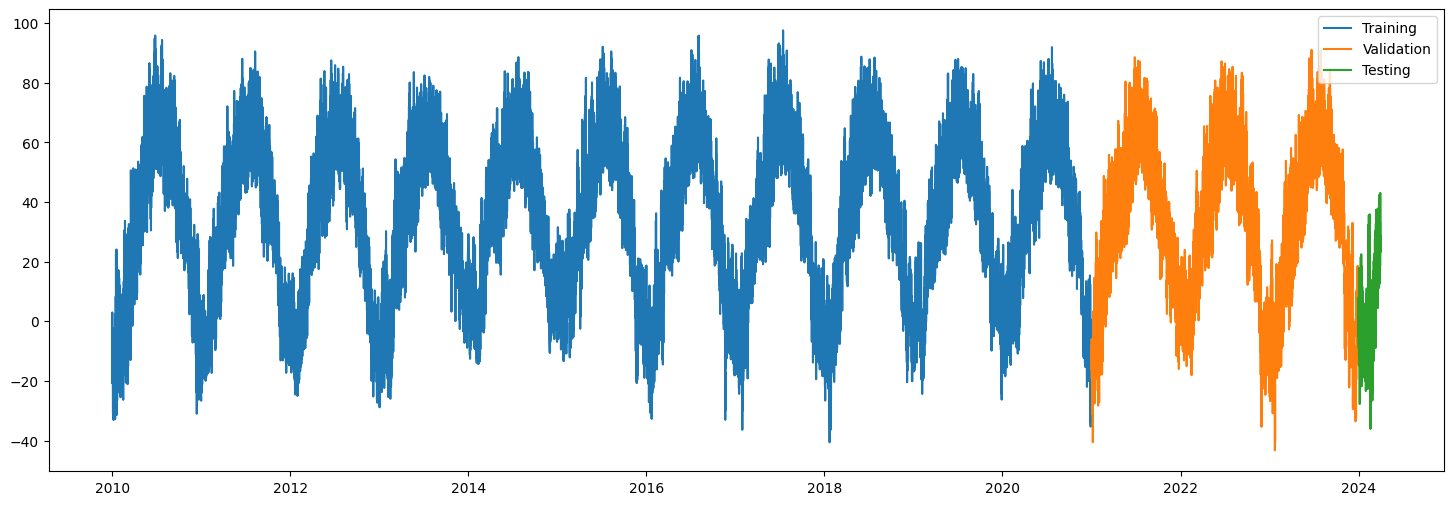

In [211]:
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.plot(train_df['t2m'], label='Training')
ax.plot(valid_df['t2m'], label='Validation')
ax.plot(test_df['t2m'], label='Testing')
ax.legend(loc='upper right')

Splitting the datasets now.

In [212]:
X_train, y_train = make_supervised(train_df["t2m"], lag_time, lead_time, len(train_df["t2m"]))

In [213]:
print(X_train.shape)
print(y_train.shape)

(93191, 24)
(93191, 1)


In [214]:
X_valid, y_valid = make_supervised(valid_df["t2m"], lag_time, lead_time, len(valid_df["t2m"]))

In [215]:
print(X_valid.shape)
print(y_valid.shape)

(25391, 24)
(25391, 1)


In [216]:
X_test, y_test = make_supervised(test_df["t2m"], lag_time, lead_time, len(test_df["t2m"]))

In [217]:
print(X_test.shape)
print(y_test.shape)

(2087, 24)
(2087, 1)


### Normalization

The last step is to normalize the data. It's known that model training is quicker and produces more accurate models if the training dataset is scaled.  

Min-Max Normalization and Z-score standardization are the most popular methods. Normalization takes the minimum and maximum to scale the values down to a range between [0, 1] (inclusive). Meanwhile, standardization takes the mean and standard deviation and centers the values to have a mean of 0 and a standard deviation of 1. We can test to see which method works best with the dataset. I'll go with min-max normalization.

The reason I converted the input/output lists into NumPy arrays in the **make_predictions()** function is because it allows us to use NumPy functions like **min()** and **max()**. 

In [218]:
X_train_min = X_train.min()
X_train_max = X_train.max()

X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_valid = (X_valid - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

I used the minimum and maximum values of the training data to normalize the validation and test set. This will ensure that temperatures in the valid/test set don't skew the scale of the training set. Furthermore, only the input sequences get normalized as they go through the most computation.

In [219]:
print(X_train[0])
print(y_train[0])

[0.21807089 0.2294325  0.25977113 0.28201499 0.30297289 0.31520592
 0.30229053 0.29694265 0.271359   0.25316056 0.24635313 0.23041368
 0.20809506 0.1873664  0.1764464  0.17302986 0.17429715 0.18352916
 0.18404452 0.19421161 0.20012495 0.18169626 0.17676609 0.16256791]
[-20.83951187]


## Modeling

Before jumping to deep learning models, I'll make a baseline model to compare them to. The baseline model can be a naive forecast where the temperature of the previous time step is the same for the future time step.

In [220]:
def baseline_model(X_test):
	predictions = []
	for i in range(X_test.shape[0]):
		predictions.append(X_test[i][-1])
	return np.array(predictions)

In [221]:
norm_predictions = baseline_model(X_test)
# Revert to original scale
predictions = (X_train_max - X_train_min) * norm_predictions + X_train_min
print(predictions[:10])

[-5.14375687 -4.91505051 -5.5770874  -4.83745956 -2.80501556  0.42131042
  4.05951691  4.61987305  4.2067337   2.02352905]


In [222]:
mse = 0
n = y_test.shape[0]
for i in range(n):
	mse += np.square((y_test[i] - predictions[i]))
mse /= n
print(f'Mean Square Error: {mse[0]:.3f}')

Mean Square Error: 6.376


The mean square error of the naive forecast is 6.379. The other models will have to beat this score to be useful.

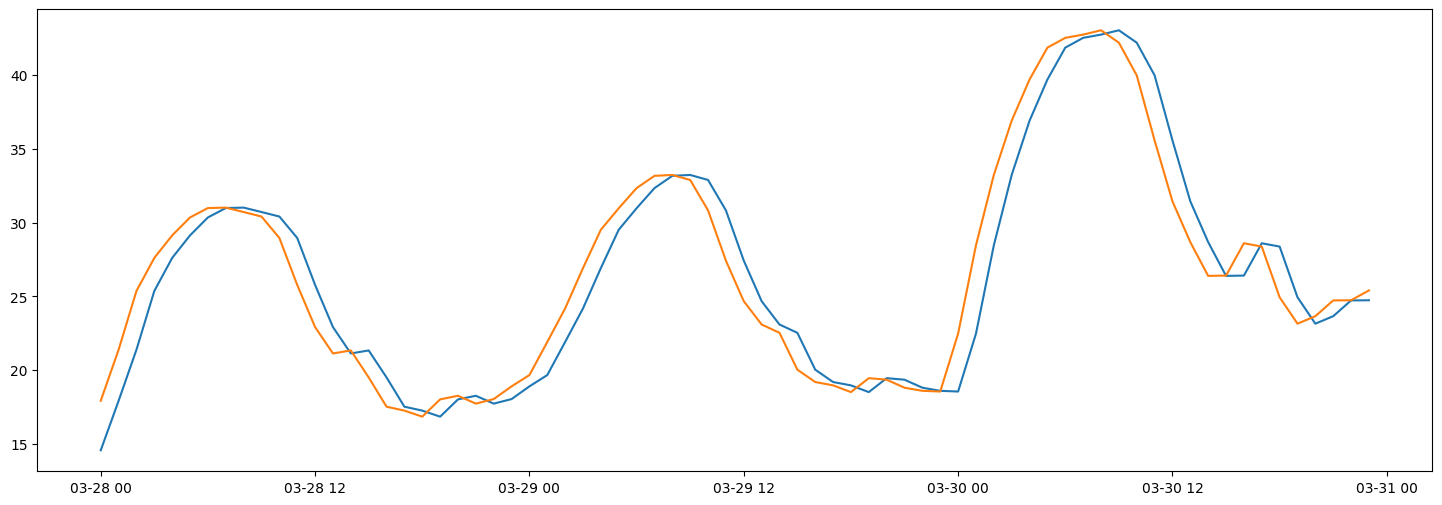

In [223]:
fig, ax = plt.subplots(1, figsize=(18, 6))
ax = plt.plot(test_df.index[-72:], predictions[-72:])
ax = plt.plot(test_df.index[-72:], y_test[-72:])